In [1]:
import copy
import numpy as np
import healpy as hp
import sqlite3
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

from slicer import Slicer, MeanMetric, FancyMetric, VectorMetric, CoaddM5Metric, PlotMoll, gen_summary_row

from rubin_sim.data import get_baseline

In [2]:
# Read in a small example visit history
baseline_file = get_baseline()

con = sqlite3.connect(baseline_file)
df = pd.read_sql("select * from observations where night < 61;", con)
con.close()

In [3]:
baseline_file

'/Users/yoachim/rubin_sim_data/sim_baseline/baseline_v4.3.1_10yrs.db'

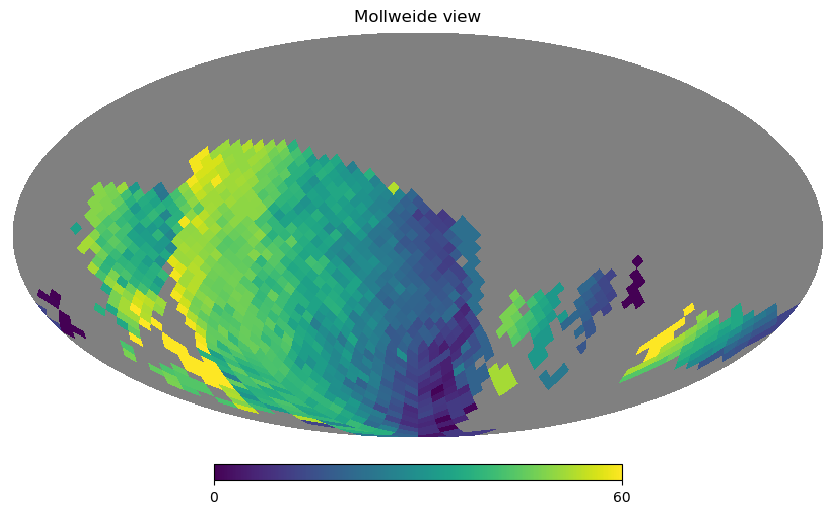

In [4]:
# Compute the mean of the night over the sky
sl = Slicer(nside=16)
metric = MeanMetric(col="night")
hp_array = sl(df, metric)
hp.mollview(hp_array)

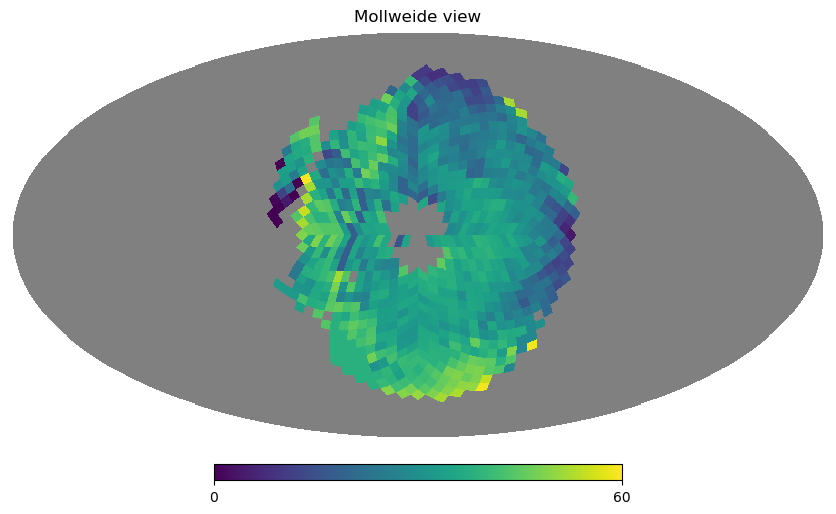

In [5]:
# Compute the mean of the night over the sky, in alt/az
sl = Slicer(nside=16, lon_col="azimuth", lat_col="altitude")
metric = MeanMetric(col="night")
hp_array = sl(df, metric)
hp.mollview(hp_array, rot=(0,90))


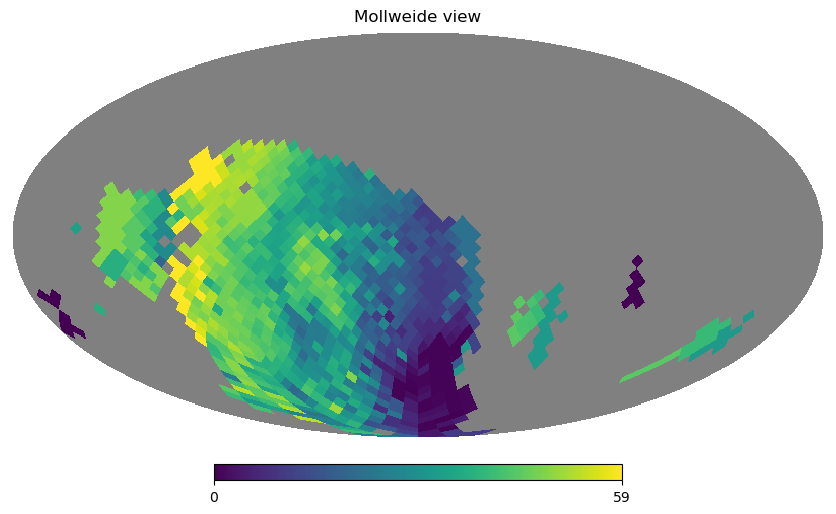

In [6]:
# select a subset of the data
r_data = df.iloc[np.where(df["filter"] == "r")[0]]
sl = Slicer(nside=16)
result = sl(r_data, metric)
hp.mollview(result)

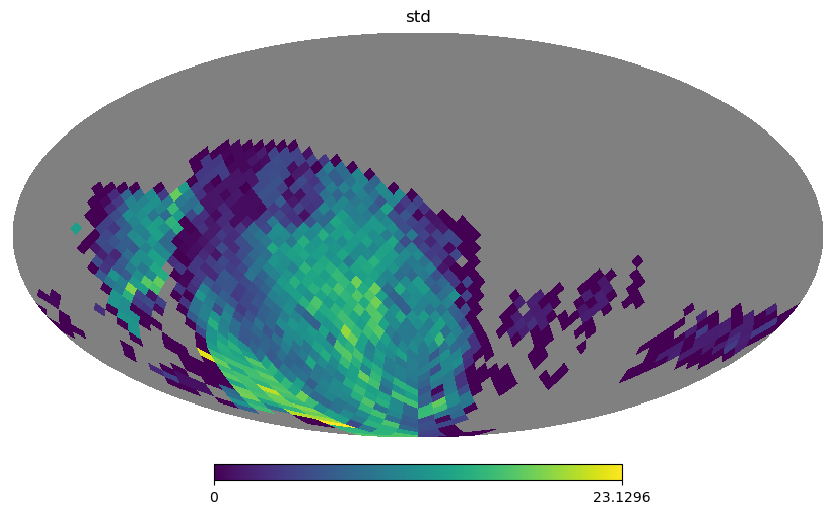

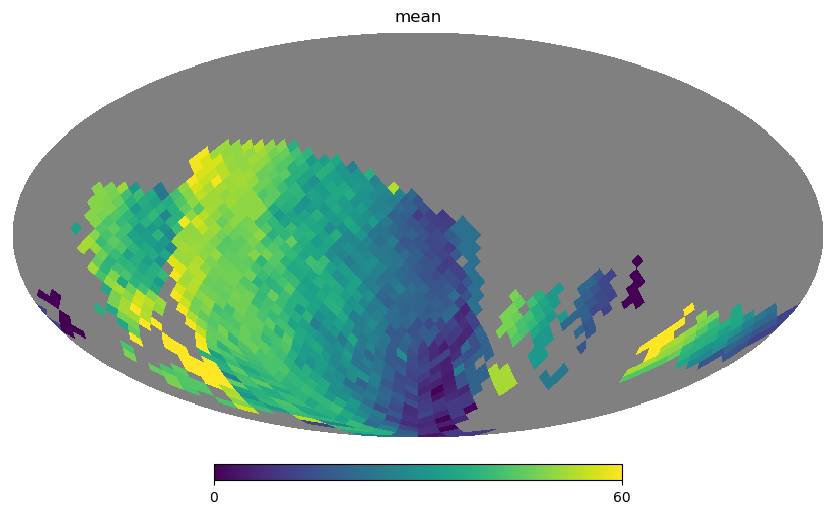

In [7]:
# A metric that returns multiple values ast each healpix, 
# e.g., N SN and z lim, or detection and classification
fancy_result = sl(df, FancyMetric())
hp.mollview(fancy_result["std"], title="std")
hp.mollview(fancy_result["mean"], title="mean")


Text(0, 0.5, 'Median over sky of summed night')

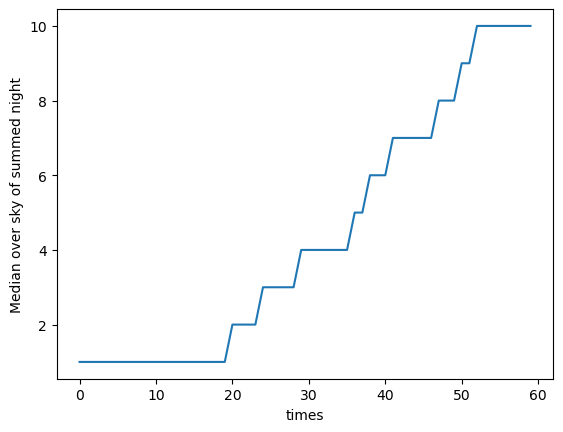

In [8]:
# A vector metric example
times = np.arange(60)
sl = Slicer(nside=16, missing=np.nan)
vm_result = sl(df, VectorMetric(times=times))
med = np.nanmedian(vm_result, axis=0)

plt.plot(times, med)
plt.xlabel("times")
plt.ylabel("Median over sky of summed night")

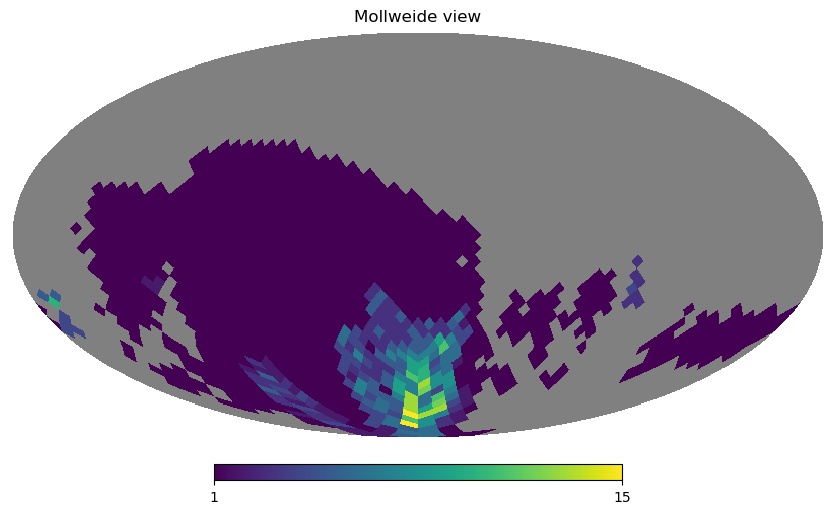

In [9]:
# A slice of the vector metric result
hp.mollview(vm_result[:,2])

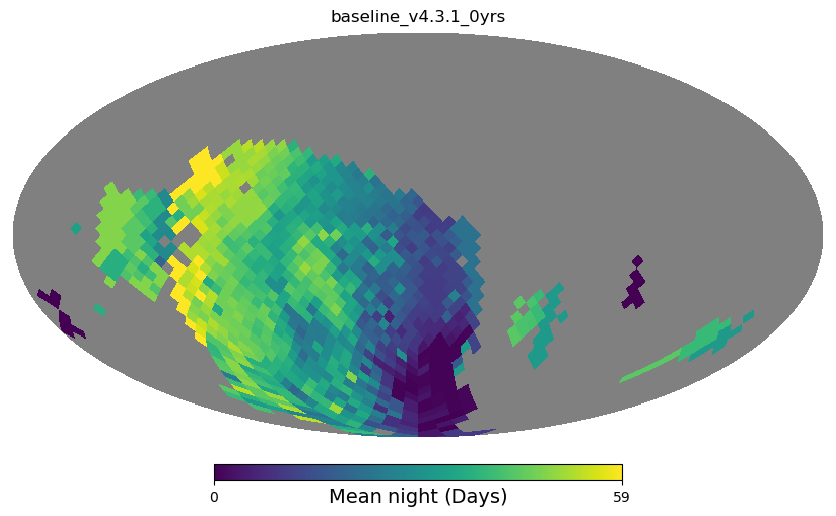

In [10]:
# Use a dict to pass along information for plots
info = {"run_name": "baseline_v4.3.1_0yrs"}
sl = Slicer(nside=16)
result, info = sl(r_data, metric, info=info)
hp.mollview(result, title=info["run_name"], unit=info["metric: name"]+' '+info["metric: col"]+' ('+info["metric: unit"]+')')

In [11]:
info

{'run_name': 'baseline_v4.3.1_0yrs',
 'slicer: nside': 16,
 'metric: name': 'Mean',
 'metric: col': 'night',
 'metric: unit': 'Days'}

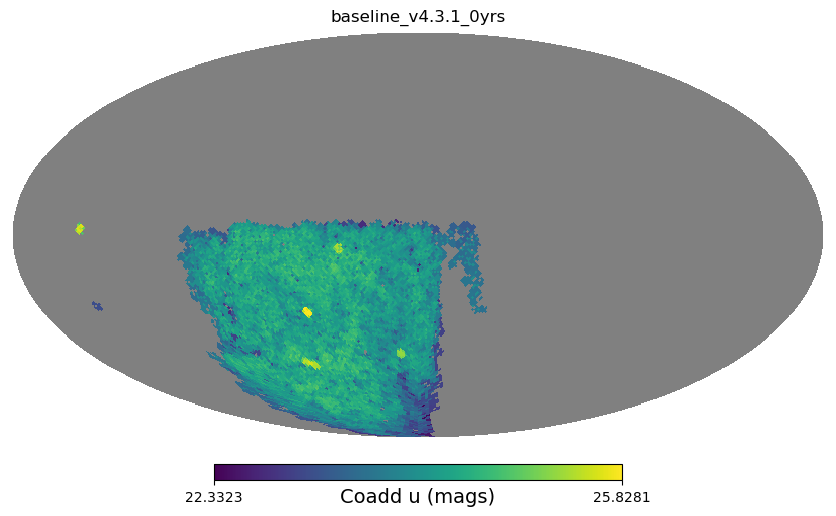

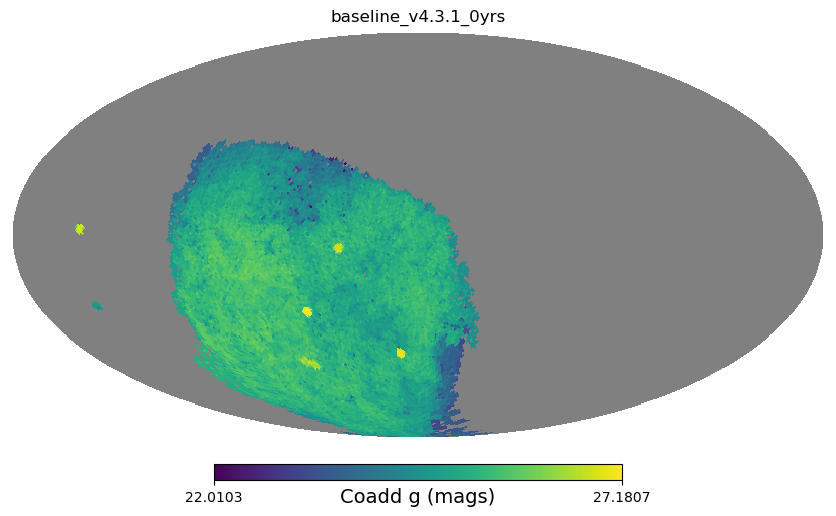

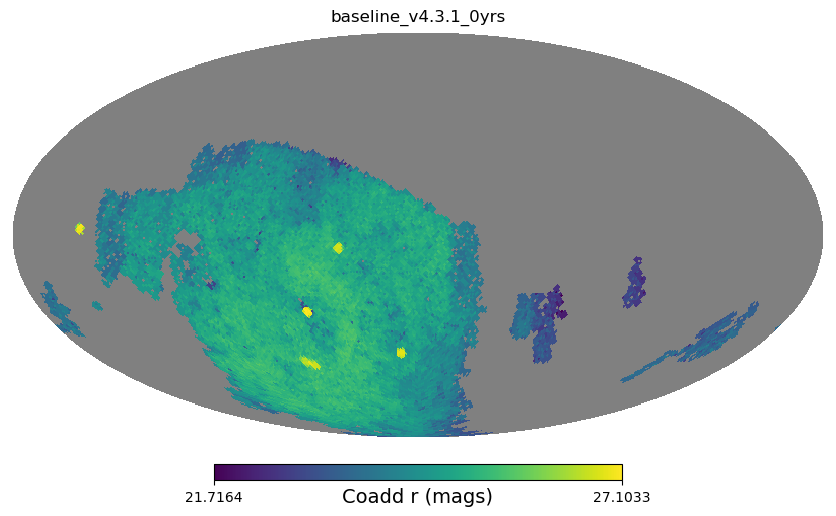

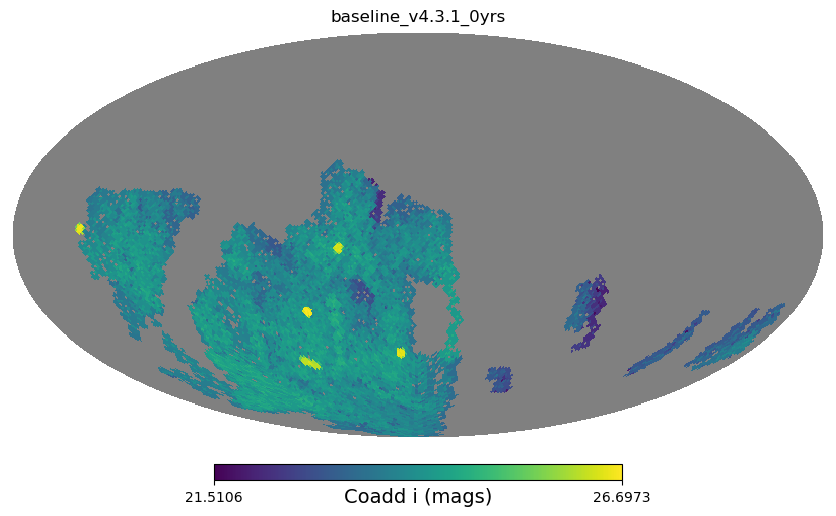

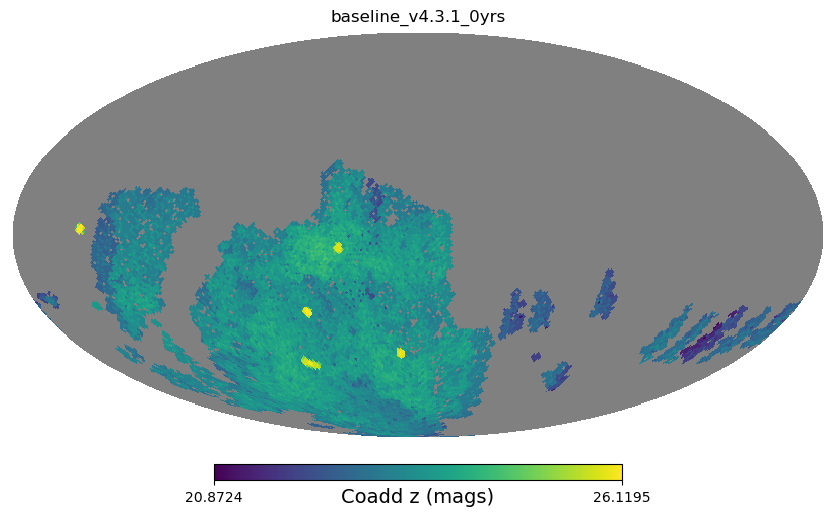

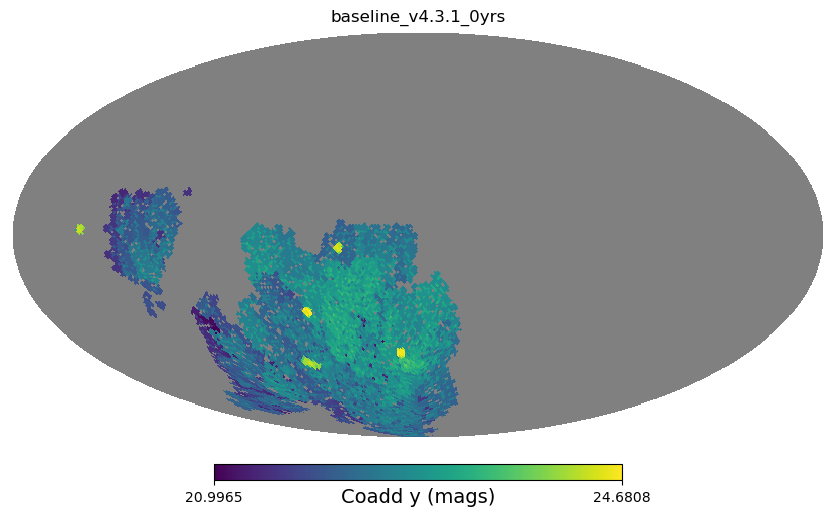

In [12]:
# Coadded depth maps in each filter, then mean and medians of those maps

summary_stats = []

for filtername in 'ugrizy':
    info = {"run_name": "baseline_v4.3.1_0yrs"}
    info["observations_subset"] =  "filter=%s" % filtername
    # select subset of data
    sub_data = df.iloc[np.where(df["filter"] == filtername)[0]]
    metric = CoaddM5Metric(unit="Coadd %s (mags)" % filtername)
    sl = Slicer(nside=64)
    # info dict used to auto-generate plot labels. Can override with plot_dict
    hp_array, info = sl(sub_data, metric, info=info)
    pm = PlotMoll(info=info)
    # add kwarg for where to save the pdf/png etc, write to results.db
    # or another method for it. Probably want to make it return a 
    # proper matplotlib figure
    pm(hp_array)
    # Do whatever stats we want on the hp_array
    summary_stats.append(gen_summary_row(info, "mean", np.nanmean(hp_array)))
    summary_stats.append(gen_summary_row(info, "median", np.nanmedian(hp_array)))


In [13]:
pd.DataFrame(summary_stats)

,run_name,observations_subset,slicer: nside,metric: name,metric: col,metric: unit,summary_name,value
0,baseline_v4.3.1_0yrs,filter=u,64,CoaddM5Metric,fiveSigmaDepth,Coadd u (mags),mean,24.166482
1,baseline_v4.3.1_0yrs,filter=u,64,CoaddM5Metric,fiveSigmaDepth,Coadd u (mags),median,24.244780
2,baseline_v4.3.1_0yrs,filter=g,64,CoaddM5Metric,fiveSigmaDepth,Coadd g (mags),mean,25.134757
3,baseline_v4.3.1_0yrs,filter=g,64,CoaddM5Metric,fiveSigmaDepth,Coadd g (mags),median,25.252899
4,baseline_v4.3.1_0yrs,filter=r,64,CoaddM5Metric,fiveSigmaDepth,Coadd r (mags),mean,24.602991
5,baseline_v4.3.1_0yrs,filter=r,64,CoaddM5Metric,fiveSigmaDepth,Coadd r (mags),median,24.734130
6,baseline_v4.3.1_0yrs,filter=i,64,CoaddM5Metric,fiveSigmaDepth,Coadd i (mags),mean,23.923856
7,baseline_v4.3.1_0yrs,filter=i,64,CoaddM5Metric,fiveSigmaDepth,Coadd i (mags),median,23.986725
8,baseline_v4.3.1_0yrs,filter=z,64,CoaddM5Metric,fiveSigmaDepth,Coadd z (mags),mean,23.401246
9,baseline_v4.3.1_0yrs,filter=z,64,CoaddM5Metric,fiveSigmaDepth,Coadd z (mags),median,23.472468
